In [1]:
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
#from gensim.models.doc2vec import Doc2Vec
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!gdown 1A6P3_YVUo-DYDbpAn_RDA4pRFydI-4ju
!gdown 1ZtOZ7UewZaR-XUSH01W2CDfrc6v8EU-s

Downloading...
From: https://drive.google.com/uc?id=1A6P3_YVUo-DYDbpAn_RDA4pRFydI-4ju
To: /content/1870_Verne-Jules_Vingt-mille-lieues-sous-les-mers.txt
100% 912k/912k [00:00<00:00, 77.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZtOZ7UewZaR-XUSH01W2CDfrc6v8EU-s
To: /content/1869_Flaubert-Gustave_L-Education-sentimentale.txt
100% 1.00M/1.00M [00:00<00:00, 116MB/s]


In [ ]:
texte_flaubert = open('1869_Flaubert-Gustave_L-Education-sentimentale.txt', encoding='utf8').read()
text_verne = open('1870_Verne-Jules_Vingt-mille-lieues-sous-les-mers.txt', encoding='utf8').read()

In [ ]:
def chunk_text(text, chunk_size=512):
    words = re.findall(r'\b\w+\b', text)
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

In [ ]:
# Process the texts into chunks
chunks_flaubert = chunk_text(texte_flaubert)
chunks_verne = chunk_text(text_verne)

In [ ]:
# Combine both sets of chunks for uniform processing
all_chunks = chunks_flaubert + chunks_verne

# Méthode 1 : BoW

In [ ]:
def bow_relative_frequencies(texts, top_n=1024):
    vectorizer = CountVectorizer(max_features=top_n)
    word_counts = vectorizer.fit_transform(texts)
    word_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    relative_freq_df = word_df.div(word_df.sum(axis=1), axis=0).fillna(0)
    return relative_freq_df

In [ ]:
# Generate relative frequency embeddings
bow_embeddings = bow_relative_frequencies(all_chunks)

# Méthode 2: Doc2Vec

In [ ]:
!gdown 1eMwacNRBeWy-KNnGJqt2CHFQh58TvT7a

Downloading...
From (original): https://drive.google.com/uc?id=1eMwacNRBeWy-KNnGJqt2CHFQh58TvT7a
From (redirected): https://drive.google.com/uc?id=1eMwacNRBeWy-KNnGJqt2CHFQh58TvT7a&confirm=t&uuid=37da9764-1a4e-4b62-ac23-dd41ba65fb9a
To: /content/doc2vec_model_novels_large.pkl
100% 315M/315M [00:02<00:00, 139MB/s]


In [ ]:
doc2vec_model = pickle.load(open('doc2vec_model_novels_large.pkl','rb'))

In [ ]:
# Infer embeddings for each chunk
doc2vec_embeddings = [doc2vec_model.infer_vector(chunk.split()) for chunk in all_chunks]

# Méthode 3 : Sentence Transformers

In [ ]:
model = SentenceTransformer("crazyjeannot/fr_literary_bge_base")
#st_embeddings = [model.encode(chunk) for chunk in all_chunks]
st_embeddings = model.encode(all_chunks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
st_embeddings = [elem.tolist() for elem in st_embeddings]

# Plotons tout cela !

In [ ]:
labels = ['Flaubert'] * len(chunks_flaubert) + ['Verne'] * len(chunks_verne)
colors = ['red' if label == 'Flaubert' else 'blue' for label in labels]

In [ ]:
def plot_embeddings_pca(embeddings, title):
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel('PCA Dimension 1', fontsize=12)
    plt.ylabel('PCA Dimension 2', fontsize=12)
    plt.show()

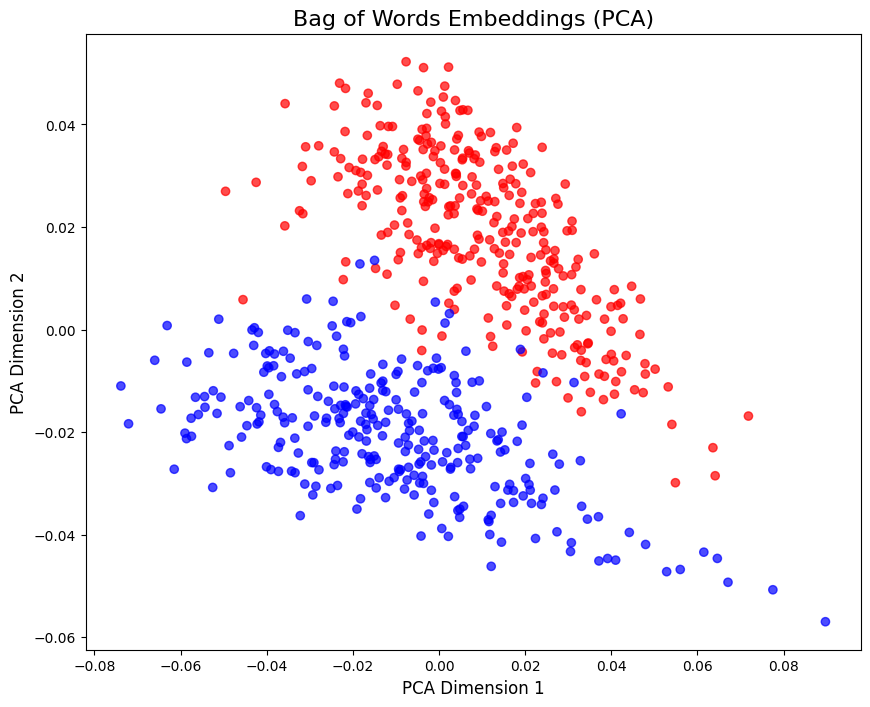

In [ ]:
plot_embeddings_pca(np.array(bow_embeddings), "Bag of Words Embeddings (PCA)")

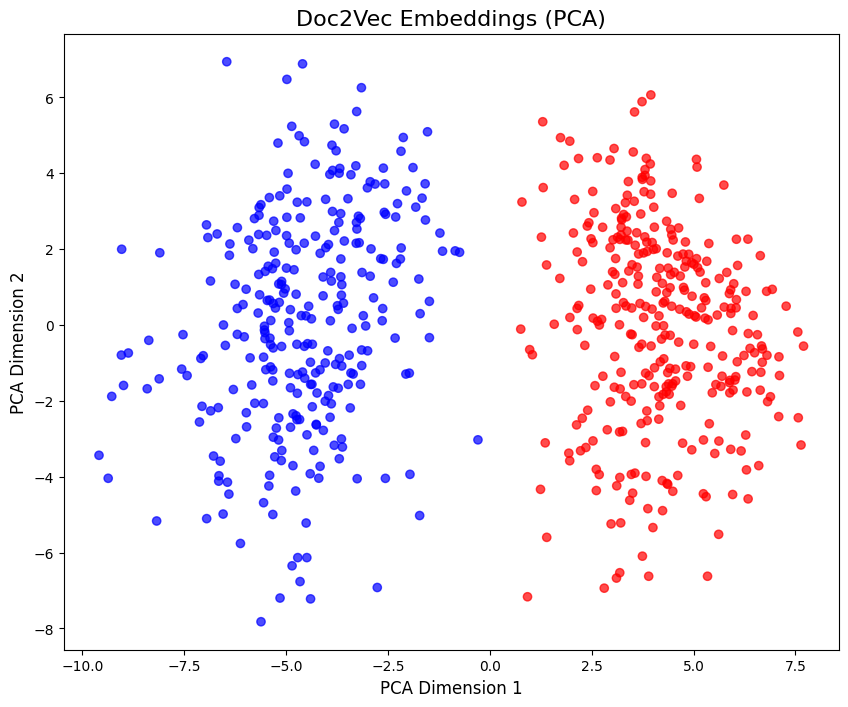

In [ ]:
plot_embeddings_pca(np.array(doc2vec_embeddings), "Doc2Vec Embeddings (PCA)")

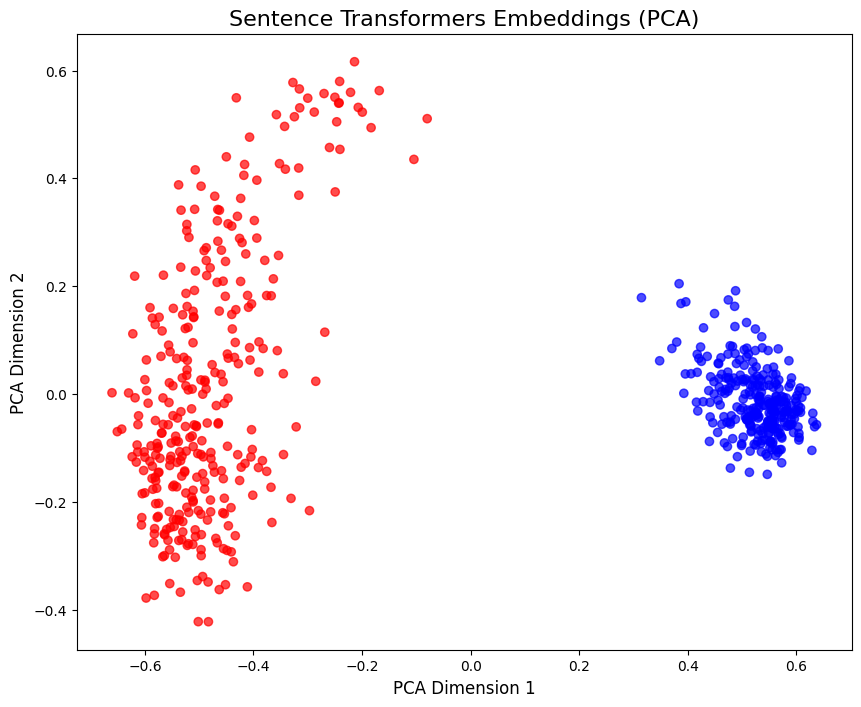

In [ ]:
plot_embeddings_pca(np.array(st_embeddings), "Sentence Transformers Embeddings (PCA)")

# Maintenant évaluons chacune des méthodes

Maintenant écrire une fonction d'évaluation qui prend en entrée les embeddings, et les labels (Flaubert ou Verne) Calculer l'embedding moyen de Flaubert, l'embedding moyen de Verne pour chaque embeddings, calculer la similarité cosinus de celui-ci à la moyenne de Flaubert / Verne si le label courant correspond à la plus petite similarité (ie si un morceau de Flaubert est plus similaire à la moyenne de Flaubert), alors compter 1, sinon compter 0 Renvoyer la précision globale

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_embeddings(embeddings, labels):
    """
    Evaluates the embeddings by comparing cosine similarity to the mean embeddings
    of Flaubert and Verne.

    Parameters:
        embeddings (np.ndarray): Array of embeddings (num_samples, embedding_dim).
        labels (list): List of labels ('Flaubert' or 'Verne') for each embedding.

    Returns:
        float: Global accuracy of classification.
    """
    # Convert embeddings to NumPy array
    #embeddings = embeddings.to_numpy()
    # Convert embeddings and labels to NumPy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Separate embeddings by label
    flaubert_embeddings = embeddings[labels == 'Flaubert']
    verne_embeddings = embeddings[labels == 'Verne']

    # Compute mean embeddings
    mean_flaubert = np.mean(flaubert_embeddings, axis=0).reshape(1, -1)
    mean_verne = np.mean(verne_embeddings, axis=0).reshape(1, -1)

    # Initialize the correct count
    correct_count = 0

    for embedding, label in zip(embeddings, labels):
        # Reshape embedding to ensure it's 2D
        embedding = embedding.reshape(1, -1)

        # Compute cosine similarity to both means
        sim_to_flaubert = cosine_similarity(embedding, mean_flaubert)[0][0]
        sim_to_verne = cosine_similarity(embedding, mean_verne)[0][0]

        # Predict label based on higher similarity
        predicted_label = 'Flaubert' if sim_to_flaubert > sim_to_verne else 'Verne'

        # Check if prediction matches the true label
        if predicted_label == label:
            correct_count += 1

    # Compute global accuracy
    accuracy = correct_count / len(labels)
    return accuracy

In [ ]:
evaluate_embeddings(bow_embeddings, labels)

0.9819672131147541

In [ ]:
evaluate_embeddings(st_embeddings, labels)

1.0

In [ ]:
evaluate_embeddings(doc2vec_embeddings, labels)

1.0

In [ ]:
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


In [ ]:
tokenizer = model.tokenizer

text1 = "Hello world"
text2 = "Completely different text"

tokens1 = tokenizer(text1)
tokens2 = tokenizer(text2)
print("Tokens for text1:", tokens1["input_ids"])
print("Tokens for text2:", tokens2["input_ids"])

Tokens for text1: [0, 35378, 8999, 2]
Tokens for text2: [0, 168318, 538, 12921, 7986, 2]


In [ ]:
model.eval()
emb = model.encode("Hello world")

In [ ]:
emb

array([ 1.3668534, -1.2117777, -1.3135076, ..., -1.0053515,  0.5375158,
        0.8251091], dtype=float32)

In [ ]:
emb

array([ 1.3668532, -1.2117776, -1.3135074, ..., -1.0053515,  0.5375158,
        0.8251091], dtype=float32)

In [2]:
model = SentenceTransformer("crazyjeannot/en-literary-bge-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [3]:
chunk = " Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?”So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.In another moment down went Alice after it, never once considering how in the world she was to get out again.The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well. "

In [4]:
model.encode(chunk)

array([ 0.8073667 , -0.14204726,  1.5619392 , ...,  0.52326775,
       -0.3138117 , -0.95877105], dtype=float32)

In [5]:
chunk = "aaaaaaaaaaaah"

In [6]:
model.encode(chunk)

array([-0.15702341,  0.08620592, -0.53263247, ...,  1.193592  ,
       -1.2489003 , -0.4576943 ], dtype=float32)